# Neural process example

We'll demonstrate training a simple neural process model using a batch of draws from a Gaussian process. First load some libraries.

In [4]:
import jax.numpy as np
import jax.random as random
import haiku as hk

%matplotlib inline
import matplotlib.pyplot as plt
import palettes

from pax import train_neural_process
from pax.data import sample_from_gaussian_process
from pax.models import NP

sns.set_style(
    "ticks", 
    {'font.family': 'serif',
     'font.serif': 'Times New Roman'}
)
palettes.set_theme()

Next we sample some data from a Gaussian process:

In [6]:
key = random.PRNGKey(12)
key, sample_key = random.split(key, 2)

(x_target, y_target), f_target = sample_from_gaussian_process(
    sample_key,
    batch_size=10,
    num_observations=200
)

Visualize the batch of draws:

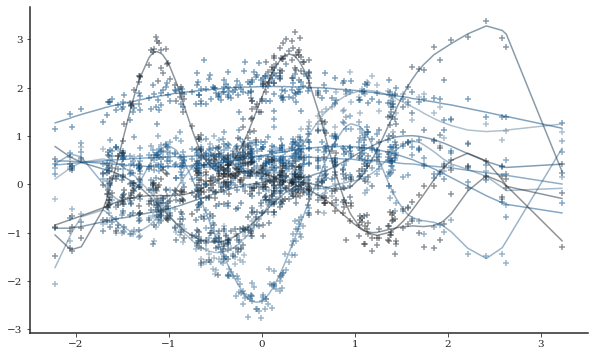

In [7]:
cols = palettes.discrete_sequential_colors(10)

_, ax = plt.subplots(figsize=(10, 6))
for i in range(x_target.shape[1]):
    x = np.squeeze(x_target[i, :, :])
    y = np.squeeze(y_target[i, :, :])
    f = np.squeeze(f_target[i, :, :])
    idxs = np.argsort(x)
    ax.plot(x[idxs], f[idxs], color=cols[i], alpha=0.5)
    ax.scatter(x[idxs], y[idxs], marker="+", color=cols[i], alpha=0.5)
plt.show()

Having sampled a data set, we can define the model. We do this as we usually define a Haiku module, i.e., by calling the `transform` function on the network structure:

In [8]:
def neural_process(**kwargs):
    dim = 128
    np = NP(
        decoder=hk.nets.MLP([dim] * 3 + [2]),
        latent_encoder=(hk.nets.MLP([dim] * 3), hk.nets.MLP([dim, dim * 2]))
    )
    return np(**kwargs)

neural_process = hk.transform(neural_process)

Next we initialize the set of parameters and train the model with a routine provided in `pax`:

In [9]:
key, init_key = random.split(key)
params = neural_process.init(
    init_key, x_context=x_target, y_context=y_target, x_target=x_target
)

In [10]:
key, train_key = random.split(key, 2)

n_context, n_target = 30, 40
params, objectives = train_neural_process(
    neural_process,
    params,
    train_key,
    x=x_target,
    y=y_target,
    n_context=n_context,
    n_target=n_target,
    n_iter=10000
)

ELBO at 0: -154.08303833007812
ELBO at 1000: -94.11767578125
ELBO at 2000: -78.95426940917969
ELBO at 3000: -48.22413635253906
ELBO at 4000: -19.753032684326172
ELBO at 5000: -32.83802795410156
ELBO at 6000: -2.4481143951416016
ELBO at 7000: -36.635398864746094
ELBO at 8000: -9.874210357666016
ELBO at 9000: -35.30583572387695


That't it! Finally, we define a set of data points for a batch and make some predictions: 

In [17]:
key, sample_key = random.split(key, 2)

sample_idxs = random.choice(
    sample_key, x_target.shape[1], 
    shape=(n_context + n_target,), replace=False
)

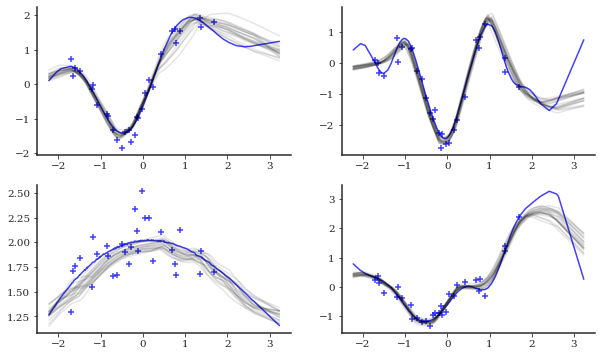

In [26]:
idxs = [0, 2, 5, 7]

_, axes = plt.subplots(figsize=(10, 6), nrows=2, ncols=2)
for _, (idx, ax) in enumerate(zip(idxs, axes.flatten())):
    x = np.squeeze(x_target[idx, :, :])
    f = np.squeeze(f_target[idx, :, :])
    y = np.squeeze(y_target[idx, :, :])

    srt_idxs = np.argsort(x)
    ax.plot(x[srt_idxs], f[srt_idxs], color="blue", alpha=0.75)
    ax.scatter(
        x[sample_idxs[:n_context]], y[sample_idxs[:n_context]], 
        color="blue", marker="+", alpha=0.75
    )

    for i in range(20):
        key, apply_key = random.split(key, 2)
        y_star = neural_process.apply(
            params=params,
            rng=apply_key,
            x_context=x[np.newaxis, sample_idxs, np.newaxis],
            y_context=y[np.newaxis, sample_idxs, np.newaxis],
            x_target=x_target[[idx], :, :]
        ).mean
        x_star = np.squeeze(x_target[[idx], :, :])
        y_star = np.squeeze(y_star)
        ax.plot(x_star[srt_idxs], y_star[srt_idxs], color="black", alpha=0.1)
plt.show()